In [16]:
# Alejandro Flores Hernández 1709458
# Marc Dalmau Guamis 1710713

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
cotxes = "Cars_Data_6k.csv"
dftrain = pd.read_csv(cotxes)


In [18]:
#veiem que hi ha columnes amb -s que representen valors nuls
#les substituim per NaN
dftrain.replace("-", np.nan, inplace=True)

C:\Users\marcd\AppData\Local\Temp\ipykernel_2328\562233532.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftrain.replace("-", np.nan, inplace=True)


In [19]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)
#treiem tank ja que esta buida sencera
dftrain = dftrain.drop(columns=["Tank"])



Percentatge de dades del train que falten per variable:

Tank            100.000000
Trunk            22.769128
Location         18.951950
Emissions        14.716223
Consumption       3.047045
Vmax              2.645237
0to100            0.435292
Sticker           0.418550
Weight            0.334840
Width             0.150678
Height            0.066968
KM                0.000000
Name              0.000000
Brand             0.000000
Unnamed: 0        0.000000
Year              0.000000
CV                0.000000
Fuel              0.000000
Length            0.000000
Transmission      0.000000
One_owner         0.000000
Keys_num          0.000000
Extras_num        0.000000
Price             0.000000
dtype: float64


In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Copia del dataframe original
df = dftrain.copy()

# Separar columnas por tipo
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# -----------------------------------------
# 1. Imputación de columnas NUMÉRICAS con KNN
# -----------------------------------------

# Escalar solo las numéricas
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

# Aplicar KNN Imputer
imputer = KNNImputer(n_neighbors=5)
X_num_imputed_scaled = imputer.fit_transform(X_num)

# Desescalar numéricas
X_num_imputed = scaler.inverse_transform(X_num_imputed_scaled)

# Crear dataframe final numérico
df_num_final = pd.DataFrame(X_num_imputed, columns=num_cols)

# -----------------------------------------
# 2. Imputación de columnas CATEGÓRICAS con la moda
# -----------------------------------------

df_cat_final = df[cat_cols].copy()

for col in cat_cols:
    df_cat_final[col] = df_cat_final[col].fillna(df_cat_final[col].mode()[0]) #CANVIAR 

# -----------------------------------------
# 3. Reconstruir el dataframe COMPLETO (sin errores)
# -----------------------------------------

df_knn = df.copy()  # copia estructura original

# Reemplazar numéricas y categóricas con las imputadas
df_knn[num_cols] = df_num_final[num_cols]
df_knn[cat_cols] = df_cat_final[cat_cols]

# Comprobación final
print("NaNs restantes por columna:")
print(df_knn.isnull().sum())

# Guardar como nuevo dftrain
dftrain = df_knn.copy()


NaNs restantes por columna:
Unnamed: 0      0
Brand           0
Name            0
Sticker         0
Year            0
KM              0
Fuel            0
CV              0
Transmission    0
One_owner       0
Location        0
Length          0
Width           0
Height          0
Weight          0
Trunk           0
Vmax            0
0to100          0
Consumption     0
Emissions       0
Keys_num        0
Extras_num      0
Price           0
dtype: int64


In [21]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)

#

Percentatge de dades del train que falten per variable:

Unnamed: 0      0.0
Brand           0.0
Name            0.0
Sticker         0.0
Year            0.0
KM              0.0
Fuel            0.0
CV              0.0
Transmission    0.0
One_owner       0.0
Location        0.0
Length          0.0
Width           0.0
Height          0.0
Weight          0.0
Trunk           0.0
Vmax            0.0
0to100          0.0
Consumption     0.0
Emissions       0.0
Keys_num        0.0
Extras_num      0.0
Price           0.0
dtype: float64


In [22]:
#crear noves mitjanes, per exemple preu mitjà per marca i model o preu per model NOU
import pandas as pd

# --- Basic aggregations per Brand ---
dftrain['brand_mean_price'] = dftrain.groupby('Brand')['Price'].transform('mean')
dftrain['brand_max_price']  = dftrain.groupby('Brand')['Price'].transform('max')
dftrain['brand_min_price']  = dftrain.groupby('Brand')['Price'].transform('min')

# --- Aggregations per Model (Brand + Name) ---
dftrain['model_mean_price'] = dftrain.groupby(['Brand', 'Name'])['Price'].transform('mean')
dftrain['model_max_price']  = dftrain.groupby(['Brand', 'Name'])['Price'].transform('max')
dftrain['model_min_price']  = dftrain.groupby(['Brand', 'Name'])['Price'].transform('min')

In [23]:
categorical_cols = ["Sticker", "Fuel", "Transmission", "Name", "Brand", "Location"]

dftrain = pd.get_dummies(dftrain, columns=categorical_cols, drop_first=True)

#print(dftrain.head())

bool_cols = dftrain.select_dtypes(include='bool').columns
dftrain[bool_cols] = dftrain[bool_cols].astype(int)

# Comprovem
print(dftrain[bool_cols].head())

   One_owner  Sticker_B  Sticker_C  Sticker_ECO  Fuel_Eléctrico  Fuel_GLP  \
0          1          0          1            0               0         0   
1          1          0          1            0               0         0   
2          0          0          1            0               0         0   
3          1          0          1            0               0         0   
4          0          0          1            0               0         0   

   Fuel_GNC  Fuel_Gasolina  Fuel_Híbrido  Fuel_Híbrido Enchufable  ...  \
0         0              0             0                        0  ...   
1         0              0             0                        0  ...   
2         0              0             0                        0  ...   
3         0              1             0                        0  ...   
4         0              1             0                        0  ...   

   Location_Málaga  Location_Navarra  Location_Oviedo  Location_Pontevedra  \
0             

In [24]:
#normalitzem les dades
scaler = StandardScaler()

#deixem fora les columnes no numeriques
cols_to_scale=[
    "Year",
    "KM",
    "CV",
    "Length",
    "Width",
    "Height",
    "Weight",
    "Trunk",
    "Vmax",
    "0to100",
    "Consumption",
    "Emissions",
    "Keys_num",
    "Extras_num",
    "brand_mean_price",
    "brand_max_price",
    "brand_min_price",
    "model_mean_price",
    "model_max_price",
    "model_min_price",
]


df_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])
df_scaled = pd.DataFrame(df_scaled_values, columns=cols_to_scale, index=df.index)
df_final = pd.concat([df_scaled,dftrain[bool_cols],dftrain["Price"]], axis=1)
print(df_final.head())

       Year        KM        CV    Length     Width    Height    Weight  \
0  1.087942 -0.595708 -0.644779 -0.725735 -0.269508 -0.739005 -0.924807   
1  0.270926 -0.429414 -0.073151  0.129531  0.439627  1.362167  0.176627   
2 -0.273752 -0.267556 -0.481457  0.255306  0.350985  0.230767 -0.031190   
3 -0.546091 -0.583035 -1.195993 -0.725735 -0.624076 -0.254119 -1.855830   
4  0.543264 -0.166223  0.539309  0.104376  0.085059  0.123014 -0.301353   

      Trunk      Vmax    0to100  ...  Location_Navarra  Location_Oviedo  \
0 -0.713341 -0.123165 -0.141901  ...                 0                0   
1  0.005873 -0.554348 -0.365804  ...                 0                0   
2  0.315185 -0.410620 -0.077386  ...                 0                0   
3 -0.383911 -1.368804  0.021283  ...                 0                0   
4  0.616953  0.355927 -0.153285  ...                 0                0   

   Location_Pontevedra  Location_Santander  Location_Sevilla  Location_Toledo  \
0                

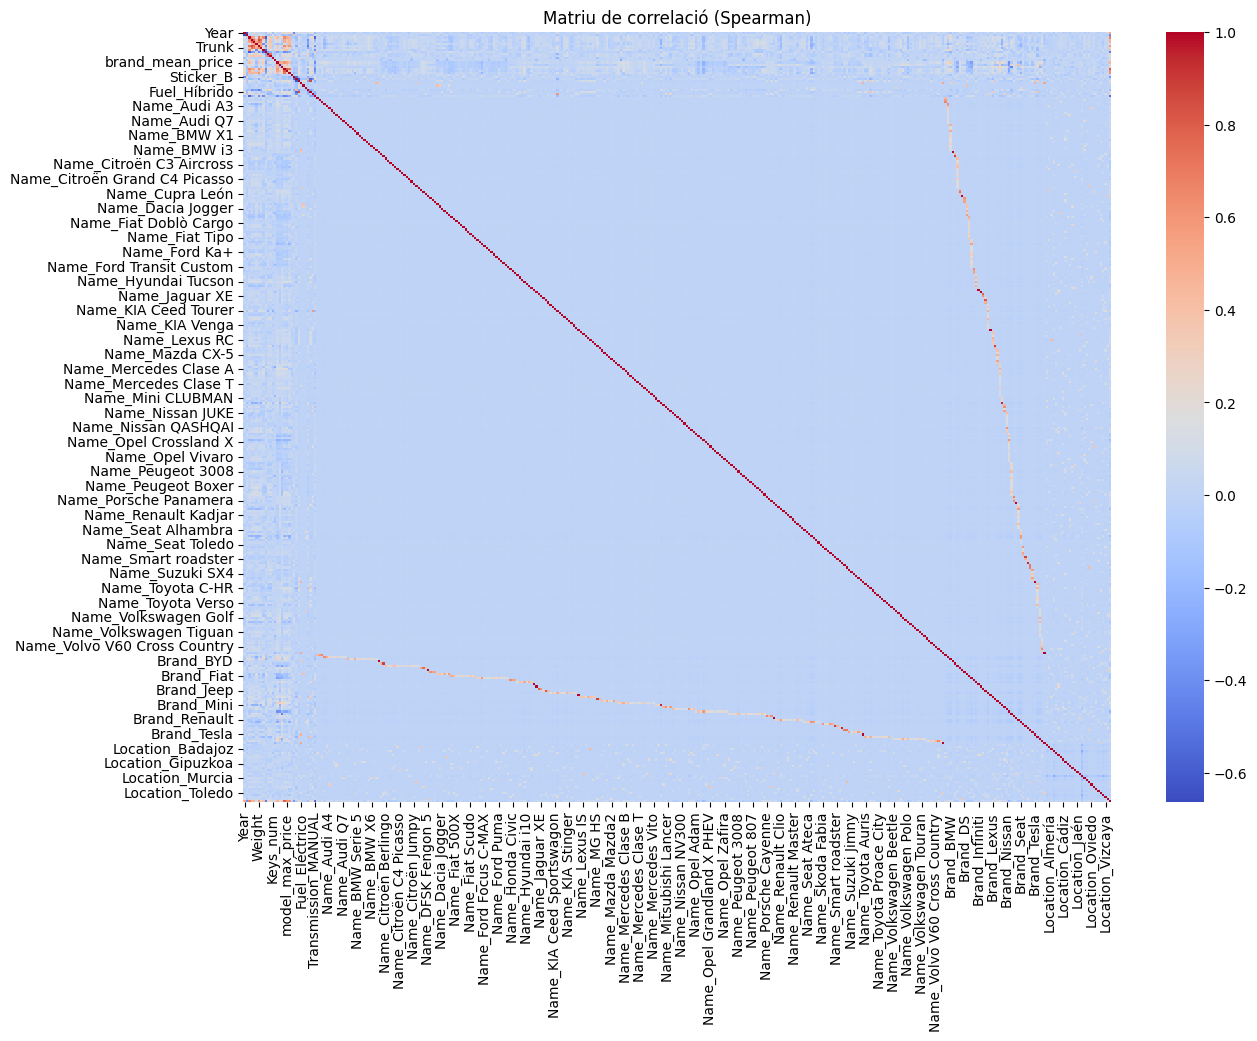

Price                  1.000000
model_mean_price       0.793910
CV                     0.674583
model_max_price        0.627756
model_min_price        0.605311
                         ...   
Brand_Opel            -0.210729
Sticker_B             -0.342572
KM                    -0.403095
0to100                -0.470578
Transmission_MANUAL   -0.524723
Name: Price, Length: 369, dtype: float64


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación Spearman (incluye solo numéricas automáticamente)
corr_matrix = df_final.corr(method="spearman")

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matriu de correlació (Spearman)")
plt.show()

# Variables ordenadas por correlación con Price
corr_with_price = corr_matrix["Price"].sort_values(ascending=False)
print(corr_with_price)


# HEM DE FER LA MATRIU DE CORRELACIÓ AMB LES VARIABLES INICIALS

In [26]:
X = df_final.drop(columns=["Price"])
y = df_final["Price"]


In [27]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
# === IMPORTS COMPLETOS PARA TODOS LOS MODELOS ===

# Modelos lineales
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    SGDRegressor
)

# Árboles y modelos de ensamble
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

# Vecinos
from sklearn.neighbors import KNeighborsRegressor

# Máquinas de soporte vectorial
from sklearn.svm import SVR

# Procesos Gaussianos
from sklearn.gaussian_process import GaussianProcessRegressor

# Partial Least Squares
from sklearn.cross_decomposition import PLSRegression

# Selección de características
from sklearn.feature_selection import SequentialFeatureSelector

# Validación cruzada
from sklearn.model_selection import KFold

# Otras utilidades
import pandas as pd
import numpy as np


# --- KFold para cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- MODELOS ---
modelos_estimadores = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "SVR_linear": SVR(kernel="linear"),
    "SVR_rbf": SVR(kernel="rbf"),
    "DecisionTree_max_depth3": DecisionTreeRegressor(max_depth=3, random_state=42),
    "RandomForest_max_depth10": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "GradientBoosting_lr05": GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3, random_state=42),
    "ElasticNet_l1": ElasticNet(alpha=0.01, l1_ratio=1.0),
    "ElasticNet_l2": ElasticNet(alpha=0.01, l1_ratio=0.0),
    "SGDRegressor_huber": SGDRegressor(loss="huber", max_iter=1000, tol=1e-3, random_state=42)
}



In [28]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

In [29]:
modelos_columnas = {
    "LinearRegression": list(X_train.columns),
    "Ridge": list(X_train.columns),
    "Lasso": list(X_train.columns),
    "ElasticNet": list(X_train.columns),
    "BayesianRidge": list(X_train.columns),
    "SGDRegressor": list(X_train.columns),
    "DecisionTree": list(X_train.columns),
    "RandomForest": list(X_train.columns),
    "GradientBoosting": list(X_train.columns),
    "AdaBoost": list(X_train.columns),
    "KNeighbors": list(X_train.columns),
    "SVR_linear": list(X_train.columns),
    "SVR_rbf": list(X_train.columns),
    "DecisionTree_max_depth3": list(X_train.columns),
    "RandomForest_max_depth10": list(X_train.columns),
    "GradientBoosting_lr05": list(X_train.columns),
    "ElasticNet_l1": list(X_train.columns),
    "ElasticNet_l2": list(X_train.columns),
    "SGDRegressor_huber": list(X_train.columns)
}

In [30]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from copy import deepcopy




# --- Cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negativo para que cross_val_score funcione

# --- Diccionario para almacenar los resultados ---
model_scores = {}

# --- Evaluar cada modelo con sus variables seleccionadas ---
for nombre_modelo, modelo in modelos_estimadores.items():
    features = modelos_columnas.get(nombre_modelo)
    
    if features is None or len(features) == 0:
        print(f"{nombre_modelo} no tiene variables seleccionadas, se omite.")
        model_scores[nombre_modelo] = None
        continue
    
    X_subset = X_train[[col for col in features if col in X_train.columns]]
    
    try:
        scores = cross_val_score(modelo, X_subset, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1)
        mean_score = -np.mean(scores)  # convertir de negativo a positivo
        model_scores[nombre_modelo] = mean_score
        print(f"{nombre_modelo} - MSE promedio: {mean_score:.4f}")
    
    except Exception as e:
        print(f"Error evaluando {nombre_modelo}: {e}")
        model_scores[nombre_modelo] = None

# --- Elegir el mejor modelo ---
best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
print(f"\nMejor modelo: {best_model[1]} con MSE = {best_model[0]:.4f}")
# Mostrar MSE CV (ya en model_scores) y MSE en test para cada modelo

model_test_scores = {}
print("\nComparativa CV vs Test MSE:")
for nombre_modelo, modelo in modelos_estimadores.items():
    cv_mse = model_scores.get(nombre_modelo)
    feats = modelos_columnas.get(nombre_modelo)
    if cv_mse is None or not feats:
        print(f"{nombre_modelo}: CV MSE = {cv_mse} -> omitido (sin features o error CV).")
        continue

    cols = [c for c in feats if c in X_train.columns]
    if len(cols) == 0:
        print(f"{nombre_modelo}: no hay columnas válidas en train/test, omito test.")
        continue

    try:
        m = deepcopy(modelo)
        m.fit(X_train[cols], y_train)
        y_pred = m.predict(X_test[cols])
        test_mse = mean_squared_error(y_test, y_pred)
        model_test_scores[nombre_modelo] = test_mse

        ratio = test_mse / cv_mse if cv_mse > 0 else np.inf
        flag = ""


        print(f"{nombre_modelo}: CV MSE = {cv_mse:.2f} | Test MSE = {test_mse:.2f} | ratio={ratio:.2f}{flag}")

    except Exception as e:
        print(f"{nombre_modelo}: error calculando Test MSE: {e}")


LinearRegression - MSE promedio: 5089068.2971
Ridge - MSE promedio: 4960802.2958
Lasso - MSE promedio: 5102587.1087
ElasticNet - MSE promedio: 6672117.9225
BayesianRidge - MSE promedio: 4883415.8958
SGDRegressor - MSE promedio: 6214176.5589
DecisionTree - MSE promedio: 11373928.9566
RandomForest - MSE promedio: 7882907.5707
GradientBoosting - MSE promedio: 4763847.6226
AdaBoost - MSE promedio: 10962584.9408
KNeighbors - MSE promedio: 5239811.9793
SVR_linear - MSE promedio: 14648360.9309
SVR_rbf - MSE promedio: 63783250.7288
DecisionTree_max_depth3 - MSE promedio: 19492747.5421
RandomForest_max_depth10 - MSE promedio: 1448477.0066
GradientBoosting_lr05 - MSE promedio: 8015457.0499
ElasticNet_l1 - MSE promedio: 5102587.1087
ElasticNet_l2 - MSE promedio: 7160500.7468
SGDRegressor_huber - MSE promedio: 367650077.3570

Mejor modelo: RandomForest_max_depth10 con MSE = 1448477.0066

Comparativa CV vs Test MSE:
LinearRegression: CV MSE = 5089068.30 | Test MSE = 4762962.63 | ratio=0.94
Ridge: C

c:\Users\marcd\OneDrive\Documentos\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.540e+09, tolerance: 3.046e+07
  model = cd_fast.enet_coordinate_descent(


Lasso: CV MSE = 5102587.11 | Test MSE = 4886325.91 | ratio=0.96
ElasticNet: CV MSE = 6672117.92 | Test MSE = 7221115.63 | ratio=1.08
BayesianRidge: CV MSE = 4883415.90 | Test MSE = 4808208.84 | ratio=0.98
SGDRegressor: CV MSE = 6214176.56 | Test MSE = 6162088.81 | ratio=0.99
DecisionTree: CV MSE = 11373928.96 | Test MSE = 12988424.40 | ratio=1.14
RandomForest: CV MSE = 7882907.57 | Test MSE = 8954379.03 | ratio=1.14
GradientBoosting: CV MSE = 4763847.62 | Test MSE = 5250559.52 | ratio=1.10
AdaBoost: CV MSE = 10962584.94 | Test MSE = 10487574.91 | ratio=0.96
KNeighbors: CV MSE = 5239811.98 | Test MSE = 5432663.41 | ratio=1.04
SVR_linear: CV MSE = 14648360.93 | Test MSE = 16844339.01 | ratio=1.15
SVR_rbf: CV MSE = 63783250.73 | Test MSE = 71629869.55 | ratio=1.12
DecisionTree_max_depth3: CV MSE = 19492747.54 | Test MSE = 21237006.06 | ratio=1.09
RandomForest_max_depth10: CV MSE = 1448477.01 | Test MSE = 1153344.04 | ratio=0.80
GradientBoosting_lr05: CV MSE = 8015457.05 | Test MSE = 93548

c:\Users\marcd\OneDrive\Documentos\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.540e+09, tolerance: 3.046e+07
  model = cd_fast.enet_coordinate_descent(


ElasticNet_l1: CV MSE = 5102587.11 | Test MSE = 4886325.91 | ratio=0.96


c:\Users\marcd\OneDrive\Documentos\Python Scripts\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e+10, tolerance: 3.046e+07
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet_l2: CV MSE = 7160500.75 | Test MSE = 7900073.27 | ratio=1.10
SGDRegressor_huber: CV MSE = 367650077.36 | Test MSE = 374637831.97 | ratio=1.02


c:\Users\marcd\OneDrive\Documentos\Python Scripts\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:

best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
print(f"\nMejor modelo: {best_model[1]} con MSE = {best_model[0]:.4f}")

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Reusar CV y scoring
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"

target_name = "RandomForest_max_depth10"
features_rf = [c for c in modelos_columnas.get(target_name, []) if c in X_train.columns]
print(features_rf)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,    # 1) ¿Las medias por marca/modelo en test coinciden con las calculadas solo con train?
    brand_mean_train = y_train.to_frame().join(X_train['Brand']).groupby('Brand')['Price'].mean()
    diffs = X_test['brand_mean_price'].map(brand_mean_train).fillna(-999) - X_test['brand_mean_price']
    print("Nº de coincidencias exactas (debe ser 0 si se calculó bien solo en train):", (diffs==0).sum())
    print("Ejemplo de discrepancias:", diffs.replace(-999, np.nan).dropna().head())
    
    # 2) ¿Alguna columna contiene directamente 'Price'?
    print([c for c in X_train.columns if 'price' in c.lower() or c.lower()=='price'])
    
    # 3) ¿Qué features dominan el modelo (importancias)?
    from sklearn.ensemble import RandomForestRegressor
    m = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_train.fillna(0), y_train)
    importances = pd.Series(m.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(importances.head(20))    # 1) ¿Las medias por marca/modelo en test coinciden con las calculadas solo con train?
    brand_mean_train = y_train.to_frame().join(X_train['Brand']).groupby('Brand')['Price'].mean()
    diffs = X_test['brand_mean_price'].map(brand_mean_train).fillna(-999) - X_test['brand_mean_price']
    print("Nº de coincidencias exactas (debe ser 0 si se calculó bien solo en train):", (diffs==0).sum())
    print("Ejemplo de discrepancias:", diffs.replace(-999, np.nan).dropna().head())
    
    print([c for c in X_train.columns if 'price' in c.lower() or c.lower()=='price'])
    
    # 3) ¿Qué features dominan el modelo (importancias)?
    from sklearn.ensemble import RandomForestRegressor
    m = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_train.fillna(0), y_train)
    importances = pd.Series(m.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(importances.head(20))
    n_jobs=-1,
    verbose=2,
    refit=True
)

print(f"\nIniciando GridSearchCV para {target_name} sobre {len(features_rf)} features...")
grid.fit(X_train[features_rf], y_train)

best_params = grid.best_params_
best_cv_neg_mse = grid.best_score_
best_cv_mse = -best_cv_neg_mse

print(f"\nMejores hiperparámetros (CV): {best_params}")
print(f"MSE CV promedio (positivo): {best_cv_mse:.4f}")

# Evaluar en test set
best_rf = grid.best_estimator_
y_pred_test = best_rf.predict(X_test[features_rf])
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"MSE en test set: {mse_test:.4f}")

modelos_estimadores[target_name] = best_rf
model_scores[target_name] = mse_test

print(f"\nRandomForest optimizado guardado en modelos_estimadores['{target_name}'].")



Mejor modelo: RandomForest_max_depth10 con MSE = 1448477.0066
['Year', 'KM', 'CV', 'Length', 'Width', 'Height', 'Weight', 'Trunk', 'Vmax', '0to100', 'Consumption', 'Emissions', 'Keys_num', 'Extras_num', 'brand_mean_price', 'brand_max_price', 'brand_min_price', 'model_mean_price', 'model_max_price', 'model_min_price', 'One_owner', 'Sticker_B', 'Sticker_C', 'Sticker_ECO', 'Fuel_Eléctrico', 'Fuel_GLP', 'Fuel_GNC', 'Fuel_Gasolina', 'Fuel_Híbrido', 'Fuel_Híbrido Enchufable', 'Transmission_MANUAL', 'Name_Alfa Romeo Giulia', 'Name_Alfa Romeo Giulietta', 'Name_Alfa Romeo Stelvio', 'Name_Audi A1', 'Name_Audi A3', 'Name_Audi A4', 'Name_Audi A5', 'Name_Audi A6', 'Name_Audi Q2', 'Name_Audi Q3', 'Name_Audi Q3 Sportback', 'Name_Audi Q7', 'Name_Audi S5', 'Name_BMW Serie 1', 'Name_BMW Serie 2', 'Name_BMW Serie 2 Active Tourer', 'Name_BMW Serie 3', 'Name_BMW Serie 5', 'Name_BMW X1', 'Name_BMW X2', 'Name_BMW X3', 'Name_BMW X4', 'Name_BMW X5', 'Name_BMW X6', 'Name_BMW Z4', 'Name_BMW i3', 'Name_BYD Seal'

In [32]:
#Mejores hiperparámetros (CV): {'bootstrap': False, 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
